## Optimization Example Notebook
Here is an example of how to setup a simple optimization test using the gradients calculated using 
JAX's automatic differentiation capabilities. 

In this notebook we setup a forward function wrapper, loss function to optimize over, and a basic gradient desent optimization loop as a basic optimization example

In [1]:
from jcm.model import Model
import jax
import jax.numpy as jnp
from jcm.physics.speedy.speedy_physics import SpeedyPhysics
from jcm.physics.speedy.params import Parameters

In [ ]:
# Setup function requirements
def create_model(parameters, time_step = 30, save_interval = 1.0, total_time = 5.0, layers = 8): 
    '''
    Returns speedy model with given parameters and specifications

    Args: 
        parameters: parameters object type (jcm.paramters)
        time_step: Model time step in minutes
        save_interval: Save interval in days
        total_time: Total integration time in days
        layers: Number of vertical layers
    '''
    model = Model(time_step = time_step, 
                        save_interval = save_interval, 
                        total_time = total_time, 
                        layers = layers,
                        physics = SpeedyPhysics(parameters = parameters))
    return model

def average_pred(predictions):
    '''
    Average over predicitions
    '''
    leaves_d = jax.tree_util.tree_leaves(predictions['dynamics'])
    avgs_d = jnp.array([jnp.mean(leaf) for leaf in leaves_d])
    leaves_p = jax.tree_util.tree_leaves(predictions['physics'])
    avgs_p = jnp.array([jnp.mean(leaf) for leaf in leaves_p])
    return jnp.concatenate((avgs_d, avgs_p))


def forward_model_wrapper(theta, theta_keys, state = None, parameters = None, args = ()):
    '''
    Returns forward model run collapsed into a single vector

    Args: 
        theta: parameters of interest (find the parameters that minimize the loss function)
        theta_keys: dictionary with parameter names 
        state: state object type (jcm.State)
        parameters: parameters object type (jcm.paramters)
        args: additional arguments for creating the model
    '''
    if parameters is None:
        parameters = Parameters.default()

    ii = 0
    for attr, params in theta_keys.items():
        for param in params:
            setattr(getattr(parameters, attr), param, theta[ii])
            ii += 1
        
    model = create_model(parameters, *args) 
    if state is None: 
        state = model.get_initial_state()
    _, model_predictions = model.unroll(state)
    return average_pred(model_predictions)
   

def loss_function(theta, forward_model, y, R_inv_sqrt, args = ()): 
    '''
    Returns data-model misfit (i.e. loss function to optimize over)

    Args: 
        theta: parameters of interest (find the parameters that minimize the loss function)
        forward_model: forward run through model with output the same shape as y
        y: data to compare model to (must be 1D vector)
        R_inv_sqrt: inverse square root of R (the assumed data errors associated to data)
        args: additional forward model function inputs
    '''

    return 0.5*jnp.linalg.norm(R_inv_sqrt*(y - forward_model(theta, *args)))**2

In [3]:
# Run forward function for true parameters
true_params = Parameters.default()  # True parameters are default parameters
model = create_model(true_params) # Create model that will run for 5 days
state = model.get_initial_state()
final_state, predictions = model.unroll(state)  # run model forward

In [4]:
# Create synthetic data
y = average_pred(predictions)
# Assumed errors
R_inv_sqrt = jnp.ones_like(y)

In [ ]:
# Set paramters to estimate
params = Parameters.default()  # Set all other parameters
theta = jnp.array([jnp.array(0.10)])  # Choose initial guess for estimating parameter/s
theta_keys = {"shortwave_radiation": ["albcls"]} # Define parameter/s to be estimated

# Define hyperparameters
step_size = 1e-5
num_iters = 10

1e-05


In [ ]:
# Loss function gradient function
grad_loss_fn = jax.grad(loss_function, argnums = 0) # Uses jax.grad to calculate gradient

# Optimization loop
thetas_GD = []
thetas_GD.append(theta)
for i in range(num_iters): # Loop run time will take a while on laptop (about 5 minutes per iteration)
    grad = grad_loss_fn(theta, forward_model_wrapper, y, R_inv_sqrt,
                         args = (theta_keys, state, params)) # Compute gradient
    print("The gradient is: ", grad[0])
    theta -= step_size * grad[0]  # Gradient descent update
    print(f"Iteration {i+1}: theta = {theta}")
    thetas_GD.append(theta)

In [ ]:
# Calculating loss function over [0,1] range
params = Parameters.default()  # Set default paramters
# Loss function loop for albcls
thetas = jnp.arange(0.0, 1.0, 0.025)
losses = []
for ii in range(len(thetas)):
    theta = jnp.array([jnp.array(thetas[ii])])
    losses.append(loss_function(theta, forward_model_wrapper, y, R_inv_sqrt,
                         args = (theta_keys, state, params)))

<Figure size 640x480 with 0 Axes>

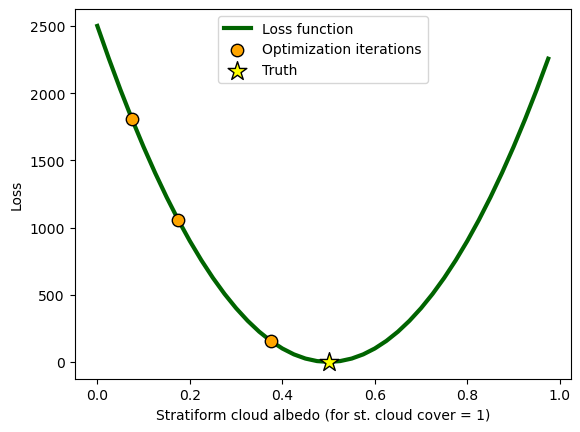

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot results
import matplotlib.pyplot as plt
plt.figure()
plt.plot(thetas, losses, linewidth = 3, color = "darkgreen", zorder = 0, label = "Loss function")
# Fit a line (1st-degree polynomial)
coeffs = jnp.polyfit(thetas, losses, deg=2)
# Define new x-values, including ones outside the original range
gd_thetas = jnp.array(thetas_GD)  # extrapolation if outside [0,4]
gd_losses = jnp.polyval(coeffs, gd_thetas)
plt.scatter(gd_thetas, gd_losses, label = "Optimization iterations",
            s = 80, marker = 'o', color = "orange", zorder = 1, edgecolors = "black")
plt.scatter(0.50, 0, label = "Truth",
            marker = "*", color = "yellow", zorder = 2, s = 200, edgecolors = "black")
plt.xlabel("Stratiform cloud albedo (for st. cloud cover = 1)")
plt.ylabel("Loss")
plt.legend()
plt.figure()